In [2]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install dtw-python


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 634 kB 24.5 MB/s 


In [56]:
from dtw import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from scipy.stats.stats import pearsonr, spearmanr
import math

91
0.8415322580645161


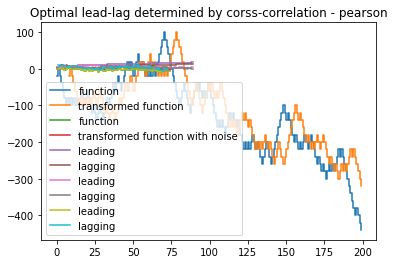

In [5]:
# benchmark 1 - shifted, scaled, offset step function
def benchmark1(shift,scale,offset):
    array_of_vals=[]
    val=0
    for i in range(0,200,1):
        if (random.randint(0,1)<0.5):
            val=val-20
            array_of_vals.append(val)
        else:
            val=val+20
            array_of_vals.append(val)
    return pd.Series(np.asarray(array_of_vals)),((pd.Series(np.asarray(array_of_vals)).shift(shift)))*scale+offset

step_f, benchmark1_step_f= benchmark1(8,1,0)
plt.title('Benchmark 1 - shift 3, scale 1.5, offset 8')
plt.plot(step_f,  ds='steps-post', label = 'function')
plt.plot(benchmark1_step_f,  ds='steps-post', label='transformed function')

plt.legend()

# benchmark 2 - shifted, scaled, offset step function + random noise

def benchmark2(shift, scale, offset, std_noise):
    #noise = np.random.random(0,std_noise,2)
    array_of_vals=[]
    array_of_vals2=[]
    val=0
    for i in range(0,300,4):
        if (random.randint(0,1)<0.5):
            val=val-1
            array_of_vals.append(val+ np.random.normal(0,std_noise))
            array_of_vals2.append(val+ np.random.normal(0,std_noise))
        else:
            val=val+1
            array_of_vals.append(val+ np.random.normal(0,std_noise))
            array_of_vals2.append(val+ np.random.normal(0,std_noise))
    return pd.Series(np.asarray(array_of_vals)),pd.Series(np.asarray(array_of_vals2)).shift(shift)*scale+offset


step_f, benchmark2_step_f= benchmark2(3,1.5,8,1)
plt.plot(step_f,  ds='steps-post', label = 'function')
plt.plot(benchmark2_step_f,  ds='steps-post', label='transformed function with noise')
plt.title('Benchmark 2 - benchmark 1 + added noise')

plt.legend()

# benchmark 3 - 1 series leading (change in price over longer horizon) and 2nd series updating quickly
def benchmark3(std_noise):

    xx=np.arange(0,90,1)
    xx=np.asarray(xx)
    yy=[]
    zz=[]

    for i in range(15):
        yy.append(5+np.random.normal(0,std_noise))

    for i in range(15):
        yy.append(5+i+np.random.normal(0,std_noise))

    for i in range(60):
        yy.append(19+np.random.normal(0,std_noise))

    for i in range(45):
        zz.append(5+np.random.normal(0,std_noise))

    for i in range(45):
        zz.append(19+np.random.normal(0,std_noise))

    yy=np.asarray(yy)
    zz=np.asarray(zz)
    return xx,4*pd.Series(yy), 3*pd.Series(zz)

# benchmark 3 - 1 series leading (change in price over longer horizon) and 2nd series updating quickly
def benchmark3b(std_noise):

    xx=np.arange(0,180,1)
    xx=np.asarray(xx)
    yy=[]
    zz=[]

    for i in range(15):
        yy.append(5+np.random.normal(0,std_noise))

    for i in range(15):
        yy.append(5+i+np.random.normal(0,std_noise))

    for i in range(150):
        yy.append(19+np.random.normal(0,std_noise))

    for i in range(90):
        zz.append(5+np.random.normal(0,std_noise))

    for i in range(90):
        zz.append(19+np.random.normal(0,std_noise))

    yy=np.asarray(yy)
    zz=np.asarray(zz)
    return xx,4*pd.Series(yy), 3*pd.Series(zz)


# benchmark 4 - 1 series leading and later both series trending together in the same direction of the big move 
def benchmark4(std_noise):
    xx=np.arange(0,90,1)
    xx=np.asarray(xx)
    yy=[]
    zz=[]

    for i in range(15):
        yy.append(5+np.random.normal(0,std_noise))

    for i in range(75):
        yy.append(10+i*0.1+np.random.normal(0,std_noise))


    for i in range(30):
        zz.append(2+np.random.normal(0,std_noise))

    for i in range(60):
        zz.append(7+i*0.1+np.random.normal(0,std_noise))

    yy=np.asarray(yy)
    zz=np.asarray(zz)
    return xx,pd.Series(yy),pd.Series( zz)
xx,leading4, lagging4 = benchmark4(0)
plt.step(xx,leading4,  label='leading')
plt.step(xx,lagging4, label = 'lagging')
plt.title('Benchmark 4 - lead-lag scenario + white noise N(0,0.25)')
plt.legend()

# benchmark 5 - 1 series leading and later both series trending together in the opposite direction of the big move
def benchmark5(std_noise):
    xx=np.arange(0,90,1)
    xx=np.asarray(xx)
    yy=[]
    zz=[]

    for i in range(15):
        yy.append(5+np.random.normal(0,std_noise))

    for i in range(75):
        yy.append(10+i*-0.1+np.random.normal(0,std_noise))


    for i in range(30):
        zz.append(2+np.random.normal(0,std_noise))

    for i in range(60):
        zz.append(7+i*-0.1+np.random.normal(0,std_noise))

    yy=np.asarray(yy)
    zz=np.asarray(zz)
    return xx,pd.Series(yy),pd.Series(zz)
xx,leading5, lagging5 = benchmark5(1.2)
plt.step(xx,leading5,  label='leading')
plt.step(xx,lagging5, label = 'lagging')
plt.title('Benchmark 5 - lead-lag scenario')
plt.legend()

rs=[]
def crosscorr(datax, datay, lag, method):
    for lag in range(-lag,lag+1,1):
        rs.append(datax.corr(datay.shift(lag),method=method))
    return np.argmax(rs), rs[np.argmax(rs)]
arg, val = crosscorr(step_f, benchmark2_step_f,50,'spearman')
print(arg)
print(val)
plt.title('Optimal lead-lag determined by corss-correlation - pearson')
plt.plot(step_f, ds='steps-post', label='leading')
plt.plot( benchmark2_step_f.shift(-2), ds='steps-post',label='lagging')
plt.legend()

Trading lagging series - corr
Trading leading series - corr


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


0

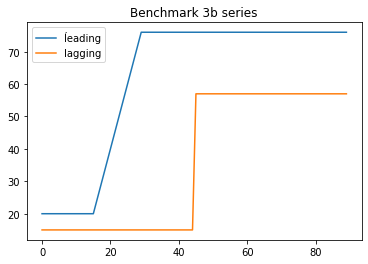

In [63]:
def DTWSignalMeasure(leading,lagging,window):
  
  sum_distances=0
  num_points=0
  mean_dtw_distance=0
  
  position=0
  total_pnl=0
  entry_price=0

  # compute average dtw distance before starting trading strategy - used as base for signal 
  for x in range(0,50,window):
    leading_section = leading[x:x+w]
    lagging_section = lagging[x:x+w]
    num_points+=1
    alignment=dtw(leading_section, lagging_section, keep_internals=True)
    sum_distances+=alignment.distance
    mean_dtw_distance=sum_distances/num_points

  # compute trading signal - trade according to the strategy
  for x in range(10,len(leading),window):
    leading_section = leading[x:x+w]
    lagging_section = lagging[x:x+w]
    alignment = dtw(leading_section, lagging_section, keep_internals=True)

    num_points+=1
    sum_distances+=alignment.distance
    
    #update mean
    mean_dtw_distance=sum_distances/num_points

    if (alignment.distance>mean_dtw_distance and position==0):
      # bet lagging will go closer to leading

      #long lagging
      if (np.mean(leading_section)>np.mean(lagging_section)):
        entry_price=lagging[x]
        print("Open long position at price:",lagging[x])
        print("Average distance:",mean_dtw_distance)
        print("Current distance:",alignment.distance)
        print("TIMESTAMP:",x)
        position=1
        #short lagging
      if (np.mean(leading_section)<np.mean(lagging_section)):
        print("Open short position at price:",lagging[x])
        print("Average distance:",mean_dtw_distance)
        print("Current distance:",alignment.distance)
        print("TIMESTAMP:",x)
        position=-1
        entry_price=lagging[x]

    #close long
    if (alignment.distance<=mean_dtw_distance and position==1):
      print("Close long position at price:", lagging[x])
      print("Pnl from trade",lagging[x]-entry_price)
      total_pnl+=(lagging[x]-entry_price)
      print("Total pnl", total_pnl)
      print("TIMESTAMP:",x)
      position=0

    #close short
    if (alignment.distance<=mean_dtw_distance and position==-1):
      print("Close short position at price:", lagging[x])
      print("Pnl from trade",entry_price-lagging[x])
      total_pnl+=(entry_price-lagging[x])
      print("Total pnl", total_pnl)
      print("TIMESTAMP:",x)
      position=0

  if (position==1):
    print("Force close long position at price:", lagging[x])
    print("Pnl from trade",lagging[x]-entry_price)
    total_pnl+=(lagging[x]-entry_price)
    print("Total pnl", total_pnl)
    print("TIMESTAMP:",x)
    position=0
  
  if position==-1:
    print("Force Close short position at price:", lagging[x])
    print("Pnl from trade",entry_price-lagging[x])
    total_pnl+=(entry_price-lagging[x])
    print("Total pnl", total_pnl)
    print("TIMESTAMP:",x)
    position=0

  return total_pnl



def EuclideanSignalMeasure(leading,lagging,window):
  
  sum_distances=0
  num_points=0
  mean_euclid_distance=0
  
  position=0
  total_pnl=0
  entry_price=0

  # compute average dtw distance before starting trading strategy - used as base for signal 
  for x in range(0,10,window):
    leading_section = leading[x:x+w]
    lagging_section = lagging[x:x+w]
    num_points+=1
    alignment=distance.euclidean(leading_section, lagging_section)
    sum_distances+=alignment
    mean_dtw_distance=sum_distances/num_points

  # compute trading signal - trade according to the strategy
  for x in range(10,len(leading),window):
    leading_section = leading[x:x+w]
    lagging_section = lagging[x:x+w]
    alignment = distance.euclidean(leading_section, lagging_section)

    num_points+=1
    sum_distances+=alignment
    
    #update mean
    mean_dtw_distance=sum_distances/num_points

    if (distance.euclidean(leading_section, lagging_section)>mean_dtw_distance and position==0):
      # bet lagging will go closer to leading

      #long lagging
      if (np.mean(leading_section)>np.mean(lagging_section)):
        entry_price=lagging[x]
        print("Open long position at price:",lagging[x])
        print("Average distance:",mean_dtw_distance)
        print("Current distance:",alignment)
        print("TIMESTAMP:",x)
        position=1
        #short lagging
      if (np.mean(leading_section)<np.mean(lagging_section)):
        print("Open short position at price:",lagging[x])
        print("Average distance:",mean_dtw_distance)
        print("Current distance:",alignment)
        print("TIMESTAMP:",x)
        position=-1
        entry_price=lagging[x]

    #close long
    if (distance.euclidean(leading_section, lagging_section)<=mean_dtw_distance and position==1):
      print("Close long position at price:", lagging[x])
      print("Pnl from trade",lagging[x]-entry_price)
      total_pnl+=(lagging[x]-entry_price)
      print("Total pnl", total_pnl)
      print("TIMESTAMP:",x)
      position=0

    #close short
    if (distance.euclidean(leading_section, lagging_section)<=mean_dtw_distance and position==-1):
      print("Close short position at price:", lagging[x])
      print("Pnl from trade",entry_price-lagging[x])
      total_pnl+=(entry_price-lagging[x])
      print("Total pnl", total_pnl)
      print("TIMESTAMP:",x)
      position=0

  if (position==1):
    print("Force close long position at price:", lagging[x])
    print("Pnl from trade",lagging[x]-entry_price)
    total_pnl+=(lagging[x]-entry_price)
    print("Total pnl", total_pnl)
    print("TIMESTAMP:",x)
    position=0
  
  if position==-1:
    print("Force Close short position at price:", lagging[x])
    print("Pnl from trade",entry_price-lagging[x])
    total_pnl+=(entry_price-lagging[x])
    print("Total pnl", total_pnl)
    print("TIMESTAMP:",x)
    position=0

  return total_pnl

def crosscorr(datax, datay, lag, method):
    for lag in range(-lag,lag+1,1):
        rs.append(datax.corr(datay.shift(lag),method=method))
    return np.argmax(rs), rs[np.argmax(rs)]


def CorrSignalMeasure(leading,lagging,window):
  
  sum_distances=0
  num_points=0
  mean_dtw_distance=0
  
  position=0
  total_pnl=0
  entry_price=0

  # compute average dtw distance before starting trading strategy - used as base for signal 
  for x in range(0,10,window):
    leading_section =np.asarray(leading[x:x+w])
    lagging_section = np.asarray(lagging[x:x+w])
    num_points+=1
    tupleA=pearsonr(leading_section, lagging_section)
    if (math.isnan(tupleA[0])):
      alignment=0
    else:
      alignment=tupleA[0]

    

    sum_distances+=alignment
    mean_dtw_distance=sum_distances/num_points

  # compute trading signal - trade according to the strategy
  for x in range(10,len(leading),window):
    leading_section = leading[x:x+w]
    lagging_section = lagging[x:x+w]
    tupleA=pearsonr(leading_section, lagging_section)
    if (math.isnan(tupleA[0])):
      alignment=0
    else:
      alignment=tupleA[0]

    num_points+=1
    sum_distances+=alignment
    
    #update mean
    mean_dtw_distance=sum_distances/num_points

    if (alignment>mean_dtw_distance and position==0):
      # bet lagging will go closer to leading

      #long lagging
      if (np.mean(leading_section)>np.mean(lagging_section)):
        entry_price=lagging[x]
        print("Open long position at price:",lagging[x])
        print("Average distance:",mean_dtw_distance)
        print("Current distance:",alignment)
        print("TIMESTAMP:",x)
        position=1
        #short lagging
      if (np.mean(leading_section)<np.mean(lagging_section)):
        print("Open short position at price:",lagging[x])
        print("Average distance:",mean_dtw_distance)
        print("Current distance:",alignment)
        print("TIMESTAMP:",x)
        position=-1
        entry_price=lagging[x]

    #close long
    if (alignment<=mean_dtw_distance and position==1):
      print("Close long position at price:", lagging[x])
      print("Pnl from trade",lagging[x]-entry_price)
      total_pnl+=(lagging[x]-entry_price)
      print("Total pnl", total_pnl)
      print("TIMESTAMP:",x)
      position=0

    #close short
    if (alignment<=mean_dtw_distance and position==-1):
      print("Close short position at price:", lagging[x])
      print("Pnl from trade",entry_price-lagging[x])
      total_pnl+=(entry_price-lagging[x])
      print("Total pnl", total_pnl)
      print("TIMESTAMP:",x)
      position=0

  if (position==1):
    print("Force close long position at price:", lagging[x])
    print("Pnl from trade",lagging[x]-entry_price)
    total_pnl+=(lagging[x]-entry_price)
    print("Total pnl", total_pnl)
    print("TIMESTAMP:",x)
    position=0
  
  if position==-1:
    print("Force Close short position at price:", lagging[x])
    print("Pnl from trade",entry_price-lagging[x])
    total_pnl+=(entry_price-lagging[x])
    print("Total pnl", total_pnl)
    print("TIMESTAMP:",x)
    position=0

  return total_pnl




xx,f,ff=benchmark3(0)
plt.title('Benchmark 3b series')
plt.plot(f, label='ĺeading')
plt.plot(ff, label='lagging')
plt.legend()


#print("Trading lagging series - dtw")
#DTWSignalMeasure(f,ff,4)
#print("Trading leading series - dtw ")
#DTWSignalMeasure(ff,f,4)

print("Trading lagging series - corr")
CorrSignalMeasure(f,ff,30)
print("Trading leading series - corr")
CorrSignalMeasure(ff,f,30)

In [55]:
pearsonr([15,15,1],[20,20,1])

(1.0, 0.0)

Trading lagging series
Open long position at price: 2.0
Average distance: 17.02
Current distance: 25.1
TIMESTAMP: 14
Close long position at price: 7.0
Pnl from trade 5.0
Total pnl 5.0
TIMESTAMP: 30
Trading leading series
Open short position at price: 5.0
Average distance: 17.02
Current distance: 25.1
TIMESTAMP: 14
Close short position at price: 11.5
Pnl from trade -6.5
Total pnl -6.5
TIMESTAMP: 30


-6.5

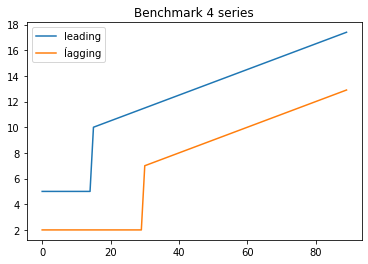

In [15]:
xx,d,dd=benchmark4(0)
plt.title('Benchmark 4 series')
plt.plot(d, label='leading')
plt.plot(dd, label='ĺagging')
plt.legend()

print("Trading lagging series")
DTWSignalMeasure(d,dd,4)
print("Trading leading series")
DTWSignalMeasure(dd,d,4)

Trading lagging series - dtw
Open short position at price: 8.023966527934236
Average distance: 14.385025434229547
Current distance: 16.098037695178895
TIMESTAMP: 10
Close short position at price: 3.9884079230813376
Pnl from trade 4.035558604852898
Total pnl 4.035558604852898
TIMESTAMP: 30
Trading leading series - dtw
Open long position at price: 5.084819988129753
Average distance: 14.385025434229547
Current distance: 16.098037695178895
TIMESTAMP: 10
Close long position at price: -1.1264769096723863
Pnl from trade -6.211296897802139
Total pnl -6.211296897802139
TIMESTAMP: 30
Trading lagging series - euclidean
Open short position at price: 8.023966527934236
Average distance: 5.8225104094942335
Current distance: 6.5025780661050705
TIMESTAMP: 10
Close short position at price: 3.9884079230813376
Pnl from trade 4.035558604852898
Total pnl 4.035558604852898
TIMESTAMP: 30
Trading leading series - euclidean
Open long position at price: 5.084819988129753
Average distance: 5.8225104094942335
Curr

-6.211296897802139

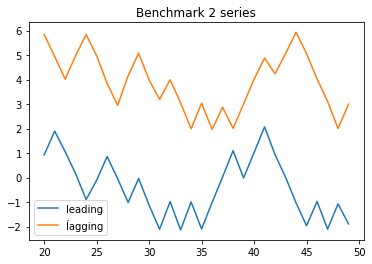

In [35]:
# benchmark 1 - shifted, scaled, offset step function
def benchmark1(shift,scale,offset):
    array_of_vals=[]
    val=0
    for i in range(0,200,1):
        if (random.randint(0,1)<0.5):
            val=val-20
            array_of_vals.append(val)
        else:
            val=val+20
            array_of_vals.append(val)
    return pd.Series(np.asarray(array_of_vals)),((pd.Series(np.asarray(array_of_vals)).shift(shift)))*scale+offset

def benchmark2(shift, scale, offset, std_noise):
    #noise = np.random.random(0,std_noise,2)
    array_of_vals=[]
    array_of_vals2=[]
    val=0
    for i in range(0,200,4):
        if (random.randint(0,1)<0.5):
            val=val-1
            array_of_vals.append(val+ np.random.normal(0,std_noise))
            array_of_vals2.append(val+ np.random.normal(0,std_noise))
        else:
            val=val+1
            array_of_vals.append(val+ np.random.normal(0,std_noise))
            array_of_vals2.append(val+ np.random.normal(0,std_noise))
    return pd.Series(np.asarray(array_of_vals)),pd.Series(np.asarray(array_of_vals2)).shift(shift)*scale+offset
  


s,ss=benchmark2(3,1,4, 0.1)
#s,ss=benchmark1(5,1,4)
plt.plot(s[20:190], label='leading')
plt.plot(ss[20:190], label='ĺagging')
plt.legend()
plt.title('Benchmark 2 series')

print("Trading lagging series - dtw")
DTWSignalMeasure(s[10:190],ss[10:190],10)
print("Trading leading series - dtw")
DTWSignalMeasure(ss[10:190],s[10:190],10)
print("Trading lagging series - euclidean")
EuclideanSignalMeasure(s[10:190],ss[10:190],10)
print("Trading leading series - euclidean")
EuclideanSignalMeasure(ss[10:190],s[10:190],10)
#DTWSignalMeasure(ss,s,4)